# Ratios Revisited
Ravi Dayabhai

In [1]:
# Notebook configurations
%config InlineBackend.figure_format = 'retina'
from IPython.display import Markdown as md

# Import dependencies
from custom.db_utils import get_connection, get_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.ticker import PercentFormatter, MaxNLocator

from sklearn import linear_model
from scipy.special import expit
import scipy.stats as stats
import statsmodels.api as sm

# Set random seed 
np.random.seed(2020)

## Introduction

At the risk of insulting your intelligence, I think it's time we reconsider ratios. For some of us, this requires going back in time to the mid-'90s. Others might not need to time travel as far (long?). Regardless of when or how you learned about ratios, division, fractions, etc., we're going to exercise our intuition today by bringing our trusty friend, the **logarithm**, along to make our lives a little less (more?) complicated.

- **Ratios are often useful for metric definition because they *relate* two quantities**. We could of course, simply subract two quanta so see how they relate to each other (e.g., "Which is bigger? By how much?"). Often, though, we care not only about the numerator or denominator (each in isolation), but how *changes* in either can be captured in one number over various intervals (e.g., over time). This often is superior to simply computing differences because absolute differences do little to contextualize the magnitude of the computed number; this feature is built into ratios (e.g., indices).

- **Ratios can sometimes be real [PITA](https://www.urbandictionary.com/define.php?term=pita)s to work with.** What if the denominator is 0? What if the numerator *and* denominator are 0? How do we express changes to ratios (e.g., percentage points of percent change when dealing with changing percentages)? How do deal with scales of ratios (even when assuming non-zero numerators and denominators)?

- **Log Transformations** of ratios (e.g., log odds ratios) can prove to be useful by making these unruly ratios easier to work with in a multitude of settings. Don't worry if $\log$s still make your palms sweat and your blood pressure rise; do a little review [here](https://www.khanacademy.org/math/algebra2/x2ec2f6f830c9fb89:logs) first and if you're deadset on plugging the "Swiss Cheese" holes in your understanding, consider watching [this](https://youtu.be/cEvgcoyZvB4?t=325).

### Contents

0. **Warm Up**
1. **Approximating Growth ($\Delta\%$)**
    - Case: Investment Returns
    
    
2. **Odds, Log Odds, Odds Ratios, Log Odds Ratios**
    - Case: Ravi Goes to Disneyland, Part III
    
    
3. **Attribution of Growth of a Ratio (or a Product)**
    - Case: Customs Attach Rate
    
    - Case: Revenue Growth
    
    
4. **Wrap Up**

### Notes to the Reader

- Sometimes mathematicians are sloppy -- they're no different than any other professional who's moving fast and breaking things. When you see the notation $\log(x)$ without a base, it often (by default) means the *natural logarithm*, i.e., $\ln(x)$. We follow that same notational ~convention~ sloppiness here.

- This isn't an exhaustive treatment of these topics; rather, this notebook is intended to (re-)wire the neurons that are meant to fire together when thinking through ratios.

## 0. Warm Up

Let $z = xy^{2}$ and $z > 0$. If $x$ increases by 50% and $y$ decreases by 20%, what is the overall effect on $z$?

> The correct answer is $z$ decreases by $4\%$. (Why?)

## 1. Approximating Growth ($\Delta\%$)

We all know how to calculate the growth rate of some quantity, say the *pro forma* year-over-year growth rate, $g$, of a company's shipments given by next year's shipments ($S_{t+1}$) and this year's shipments ($S_{t}$):

$$
S_{t+1} = S_{t} (1+g) \iff g = \frac{S_{t+1}}{S_{t}} - 1 = \frac{S_{t+1}-S_{t}}{S_{t}} \iff 1+g = \frac{S_{t+1}}{S_{t}}
$$

However, it is often useful to leverage a property of logarithms to approximate the growth rate (for relatively small growth) of a quantity:

$$
g \approx \ln(\frac{S_{t+1}}{S_{t}}) = \ln(1+g)
$$

Hark back to your exponent rules and you'll remember a useful property of logs:
$$
\ln(\frac{S_{t+1}}{S_{t}}) = \ln(S_{t+1})-\ln(S_{t}) \approx g
$$

I hope by now you're asking yourself (and anyone close enough to hear your mutterings), "*Why* is this a decent approximation?"  We can check that this a good approximation for $g\ll1$ graphically:

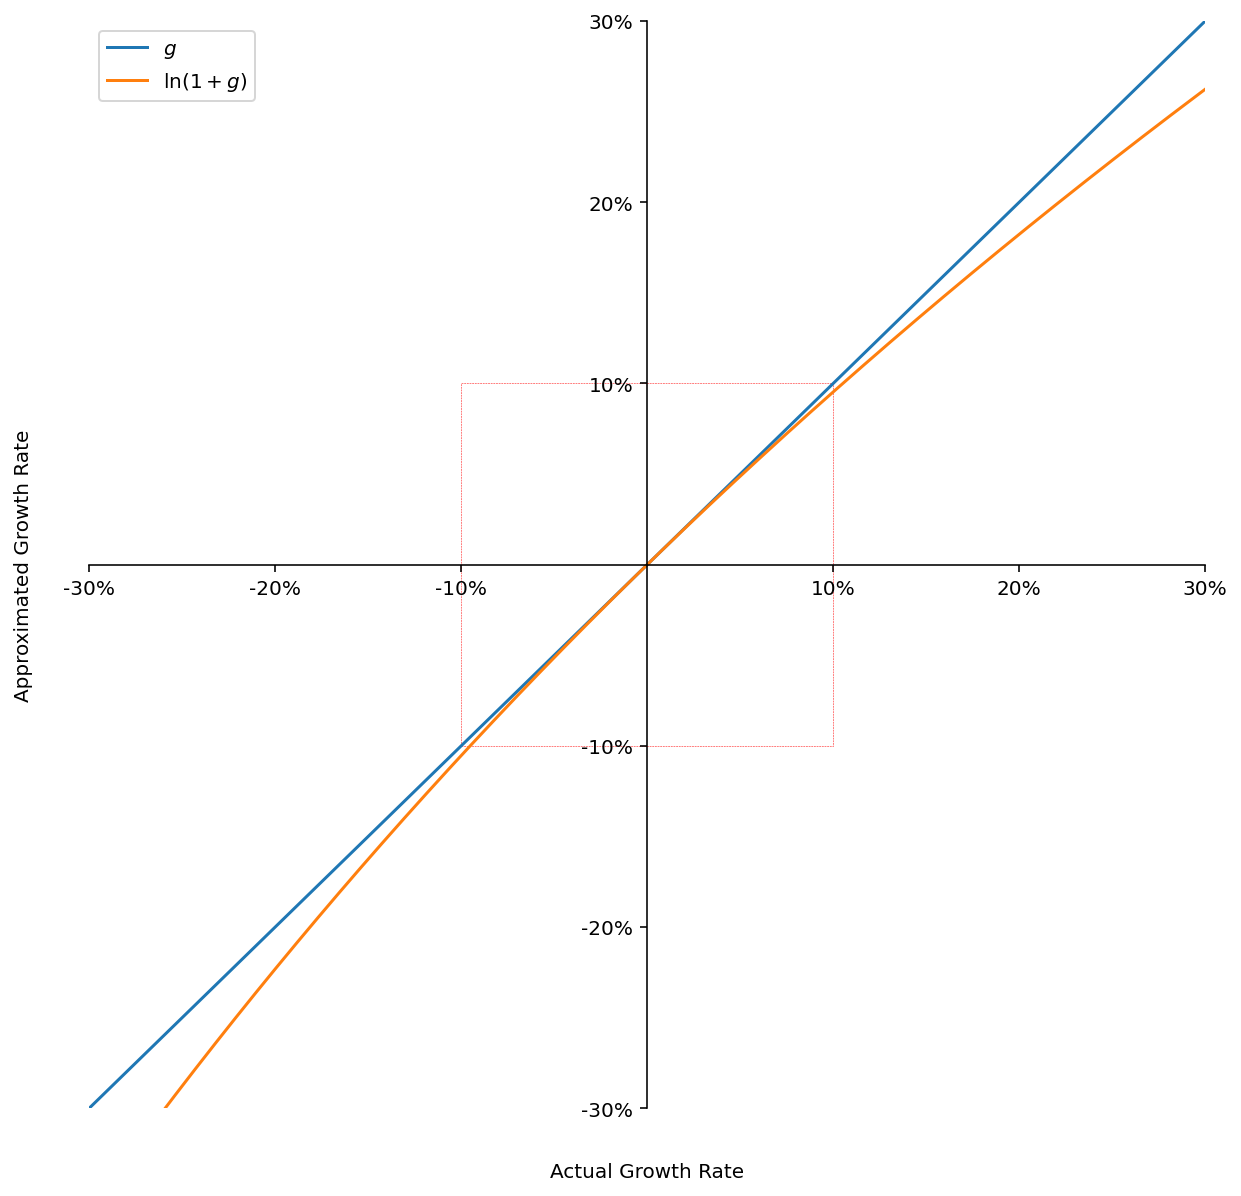

In [2]:
approx_range = 0.3
x = np.linspace(-approx_range, approx_range,1000)

# Plot ln(x) vs. x for small x
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(x, x,label="$g$")
ax.plot(x, np.log(1+x), label="$\ln(1+g)$")

ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(-approx_range, approx_range)
ax.set_ylim(-approx_range, approx_range)
ax.xaxis.set_major_formatter(PercentFormatter(1,0))
ax.yaxis.set_major_formatter(PercentFormatter(1,0))

ax.set_xlabel('Actual Growth Rate')
ax.set_ylabel('Approximated Growth Rate')
ax.xaxis.set_label_coords(0.5, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.5)

ax.xaxis.get_major_ticks()[int(len(ax.yaxis.get_major_ticks())/2)].set_visible(False)
ax.yaxis.get_major_ticks()[int(len(ax.yaxis.get_major_ticks())/2)].set_visible(False)

square = matplotlib.patches.Rectangle((-0.1,-0.1), 0.2, 0.2,
                                      edgecolor='r', ls = '--', lw=0.25,
                                      facecolor='none')
ax.add_patch(square)

ax.legend()
plt.show();


**Upshot**: The difference in the logs is (approximately) equal to the growth rate (for small log differences).

### Case: Investment Returns

Often, stock returns (especially on small time intervals) are expressed as a log ratio (e.g., $\ln(\frac{P_{1}}{P_{0}})$) rather than a percentage gain or loss. Why?

Consider the advantages of log ratios in this context ("logarithmic returns"):

- Logarithmic returns are symmetric, while ordinary returns are not: positive and negative percent ordinary returns of equal magnitude do not cancel each other out and result in a net change, but logarithmic returns of equal magnitude but opposite signs will cancel each other out.

> This means that an investment of $\$100$ that increases $50\%$ followed by a loss $50\%$ will result in a final value of $\$75$, while an investment of $\$100$ that yields a logarithmic return of $50\%$ followed by a logarithmic return of $-50\%$ will come back to $\$100$.

- Logarithmic return is also called the continuously compounded return. This means that the frequency of compounding does not matter, making returns of different assets easier to compare.

> If I buy `AMZN` at $\$2680$ today and then exit at $\$3000$ in $180$ days, I can get the average log return for this investment simply by dividing the total log return by the holding period!

$$ r_{\text{log, daily}}= \frac{\ln(3000)-\ln(2680)}{180} = .0004389 \approx 0.04\% = r_{\text{%, daily}} $$

> And the log return is approximately the percentage return because \[the smoothed\] daily returns are relatively small. We verify this fact below.

In [3]:
# Compute average daily log return
log_r_daily = np.log(3000/2680)/257
print(f"Average log daily return: {log_r_daily:.8f}")

# Convert to percentage return
pct_r_daily = np.exp(log_r_daily) - 1
print(f"Average % daily return: {pct_r_daily:.8f}")

# Compare average daily log return with daily percentage return
error = abs(log_r_daily - pct_r_daily)
print(f"Absolute Error: {error:.8f}")

Average log daily return: 0.00043889
Average % daily return: 0.00043899
Absolute Error: 0.00000010


> We can compare our investment in `AMZN` to a 180-day CD yielding a APR of $3.65\%$ easily now: $0.04\%$ daily return on the stock versus $\frac{3.65\%}{365\text{ days}} = 0.01\%$. (Obviously, this isn't risk-adjusted, but the like-for-life comparison across time and asset class was made pretty simple with logarithms!

- Logarithmic returns are time-additive. (Ponder the cases of calculating a return on a Euro-denominated asset in USD or shorting a stock, that latter of which is akin to "going back in time.")

> If we had log returns for $n$ successive periods, we could just sum them to get the total return rather than computing the cumulative \[geometric\] return using products:

> $$ \sum^{n}{r_{\text{log, daily}}} = r_{\text{log, total}}$$

> $$ \text{vs.} $$

> $$ \prod^{n}{(1+r_{\text{%, daily}})}-1 = r_{\text{%, total}}$$


- Logarithms will automatically yield an error if a price somehow becomes negative!

## 2. Odds, Log Odds, Odds Ratios, Log Odds Ratios

Are these all ratios? Yes. Are these ratios describing the same relationships? No! Let's kick things off with **odds**.

### Odds

If you remember awhile back, I mentioned that there is a technical difference between "odds" and "probabilities," even though in common parlance these two terms are used interchangeably. Realistically, they both describe the same thing: the likeliness of a particular event. *How* they do this is worth keeping in mind because in some situations it may be easier to work with one versus the other, despite both communicating the same concept.

In statistics, **odds are an expression of relative probabilities**, generally quoted as the *odds in favor*. The odds (in favor) of an event or a proposition is the ratio of the probability that the event will happen to the probability that the event will not happen. Letting $p$ be the probability of an event of interest and $q=1-p$, then *odds (in favor)* of an event of interest is $\frac{p}{q}$. To translate from odds to probability, we can perform the mathematical operations in reverse, i.e., $p=\frac{p}{p+q}$ or, equivalently, $p=\frac{o}{1+o}$ where $o$ are the odds in favor \[of an event of interest\] expressed as a fractional ratio.

This ratio holds true for counts, too. For example, if we are quoted $2:1$ odds in favor, the equivalent probability is $\frac{2}{3}=\frac{o}{1+o}=\frac{2}{1+2}$.

#### Properties of Odds

Let's start by looking at properties of odds (vs. probabilities). Here are a few observations: 

- The domain for odds are on the interval $[0,\infty)$ whereas the domain of any probability \[function\] is on the interval $[0,1]$.
- Odds can be expressed in lots of different ways, but the most common is what we've just seen (i.e., *fractional* odds). Sometimes, you'll see these expressed as *decimal* odds, which are simply $1 + \text{fractional odds}$. For example, $9:4$ odds (fractional) would translate to $3.5$ (decimal). (Note: There are other ways to express odds as well, especially in the context of gambling, but those are out of scope for this lesson.)
 - *Aside*: When you see $4:1$ odds quoted by a "bookie" (i.e., bookmaker), you are being quoted odds *against* an event occuring. The odds serve the dual purpose of encoding the payouts as well as the consensus opinion of the probability of an event \[not\] occuring.
- Calculating the *complement* of a probability \[of an event of interest\] is the logical equivalent of calculating the probability of *not* the event of interest. For an event $A$, $P(A^{c})=1-P(A)$. For odds, we simply invert the ratio (i.e., take the reciprocal): $\frac{q}{p}$!
- An increase of decrease in the odds of some amount don't yield a linearly commensurate increase or decrease in the probability; this is best observed in the plot below.

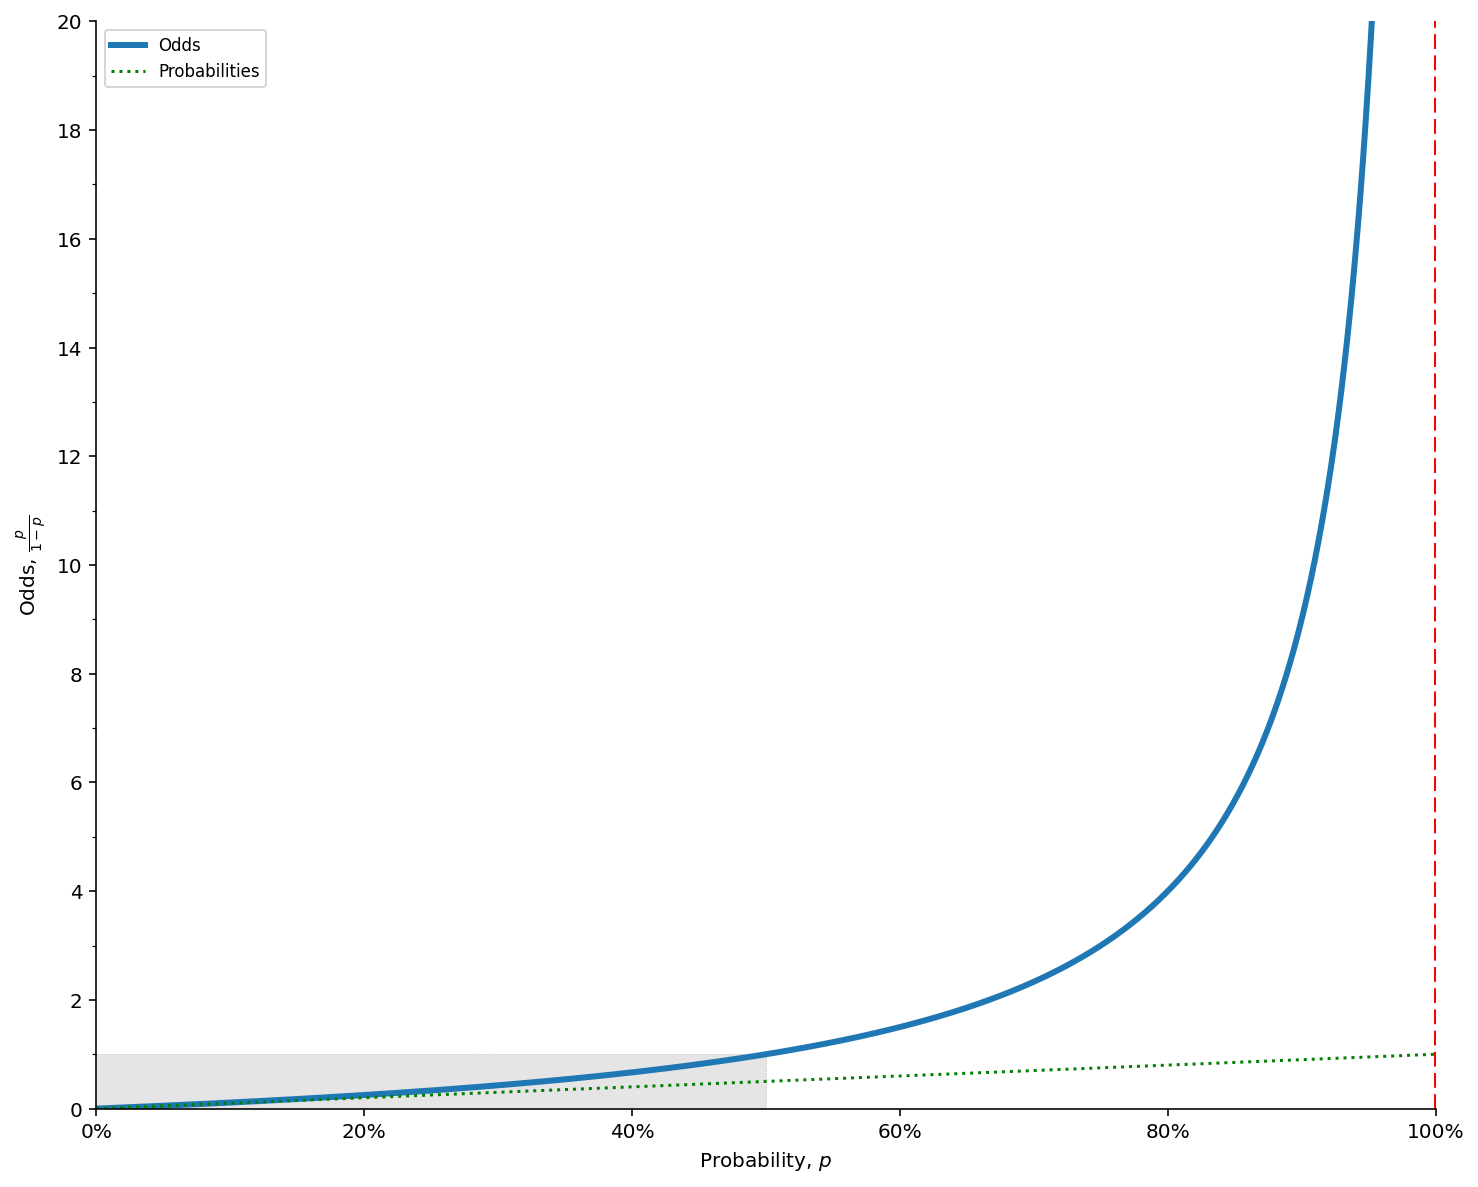

In [4]:
epsilon = 1e-8 # To prevent divide by 0 warning
p = np.linspace(0, 1-epsilon,1000)
odds = p/(1-p)

# Plot odds vs. probabilities for  x
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.plot(p, odds, lw=3, label='Odds')
ax.plot(p, p, c='green', ls='dotted', label='Probabilities')

ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 20)
ax.xaxis.set_major_formatter(PercentFormatter(1,0))
ax.yaxis.set_major_locator(MaxNLocator(nbins=ax.get_ylim()[1]/2, integer=True))
ax.yaxis.set_minor_locator(MaxNLocator(nbins=ax.get_ylim()[1]*2, integer=True))
ax.axvline(1, c='r', ls='--', lw=2)

half_domain = matplotlib.patches.Rectangle((0,0), 0.5, 1,
                                    edgecolor='k', ls = ':', lw=0.5,
                                    facecolor='grey', alpha=0.2)
ax.add_patch(half_domain)

ax.set_xlabel('Probability, $p$')
ax.set_ylabel('Odds, $\\frac{p}{1-p}$')

plt.legend(loc="upper left", fontsize='small')

plt.show();

Before we move onto log odds, let's consider how odds might help us when we're using Bayes Rule to condition on multiple pieces of evidence.

### Case: Ravi Goes to Disney, Part III

Recall Shreyas's example from the [Bayes' Rule lesson (📚.2.2)](https://github.flexport.io/rdayabhai/da_prob_stat/blob/master/Lesson_2/bayes_theorem_lesson.ipynb); yes, the one where I was subject to two different tests to prove to Disneyland officials that it was very unlikely that I was carrying COVID-19. Let's use odds to do the sequential (rather than simultaneous) updating of the priors. This will introduce the **odds form of Bayes Rule**, which falls out immediately from the definition of odds and LOTP:

$$
\underbrace{\frac{P(D|T)}{P(D^{c}|T)}}_{\text{posterior}} = \underbrace{\frac{P(T|D)}{P(T|D^{c})}}_{\text{likelihood}} \cdot \underbrace{\frac{P(D)}{P(D^{c})}}_{\text{prior}}
$$

Before Test 1 came back negative (using the same probabilities from the previous lesson), we could construct our beliefs expressed as odds:

$$
\frac{P(D)}{P(D^{c})}
$$

Once we incorporate evidence that I tested negative for Test 1, we can generate the first posterior:

$$
\frac{P(D|T_{1}^{c})}{P(D^{c}|T_1^{c})} = \frac{P(T_1^{c}|D)}{P(T_1^{c}|D^{c})} \cdot \frac{P(D)}{P(D^{c})} = \frac{0.1}{0.9} \cdot \frac{0.3}{0.7} = \frac{1}{21} \text{ odds}
$$

Treating our first posterior as the second prior, we can calculate our second (and final) posterior:

$$
\frac{P(D|T_{1}^{c} \cap T_{1}^{c})}{P(D^{c}|T_{1}^{c} \cap T_{1}^{c})} = \frac{P(T_2^{c}|D \cap T_{1}^{c})}{P(T_2^{c}|D^{c} \cap T_{1}^{c})} \cdot \frac{P(D|T_{1}^{c})}{P(D^{c}|T_1^{c})} \stackrel{\text{cond. ind.}}{=} \frac{P(T_2^{c}|D)}{P(T_2^{c}|D^{c})} \cdot \frac{P(D|T_{1}^{c})}{P(D^{c}|T_1^{c})}
$$

Remember, the last equality is enabled by the fact that the tests are *conditionally independent* (read: given whether or not I have the disease, the tests are independent). All we have to do now is plug-and-chug away:

$$
\frac{P(T_2^{c}|D)}{P(T_2^{c}|D^{c})} \cdot \frac{P(D|T_{1}^{c})}{P(D^{c}|T_1^{c})} = \frac{0.3}{0.7} \cdot \frac{1}{21} = \frac{1}{49} \text{ odds} \xrightarrow[]{\text{probability}} 2\%
$$

Notice that for **small probabilities, their correspondings odds are good approximations** (compare the green and blue lines in the chart above).

### Log Odds

Take a look at the plot above and consider the grey region, which shows the mapping for *half of the entire domain* for all probabilities -- odds map $p < 0.5$ to the interval $[0,1]$ (look at the y-axis) while the other half of the domain get mapped to $1$ to $\infty$!

Also, consider what happens when we want to reason about the complements of events:

![Odds are asymmetric](./data/odds_scale.png)


Before we address the above, consider a scenario that event $A$ is more likely than event $B$, but less likely than event $C$ (by the same amount). We could say, in the language of probabilities:

$$
\begin{align}
P(A) - P(B) &= P(C) - P(A)\\
2P(A) &= P(C) + P(B)\\
P(A) &= \frac{P(C)+P(B)}{2}
\end{align}
$$

We already know that the *arithmetic mean* (for $\mathbb{R}$) for a set of numbers is the value such that sum of the differences of each element and the mean is $0$.

$$
\sum_{i} x_{i} - \overline{x} = 0
$$

Here, the $P(A)$ is the mean of $P(B)$ and $P(C)$. For probabilities, this *symmetry* seems pretty straightforward because it's linear.

However, from both figures above, we can clearly see that $o < 1 \equiv p < 50%$ is squished and $o > 1 \equiv p > 50%$ is unbounded. This is pretty asymmetric; log odds help us win back this symmetry:

![Log odds are symmetric](./data/log_odds_scale.png)

Using $\log$ properties, we see that the symmetry is preserved:

$$
\log \frac{p}{q} + \log \frac{q}{p} = \log \frac{pq}{qp} = \log 1 = 0 \iff p + q = 1
$$

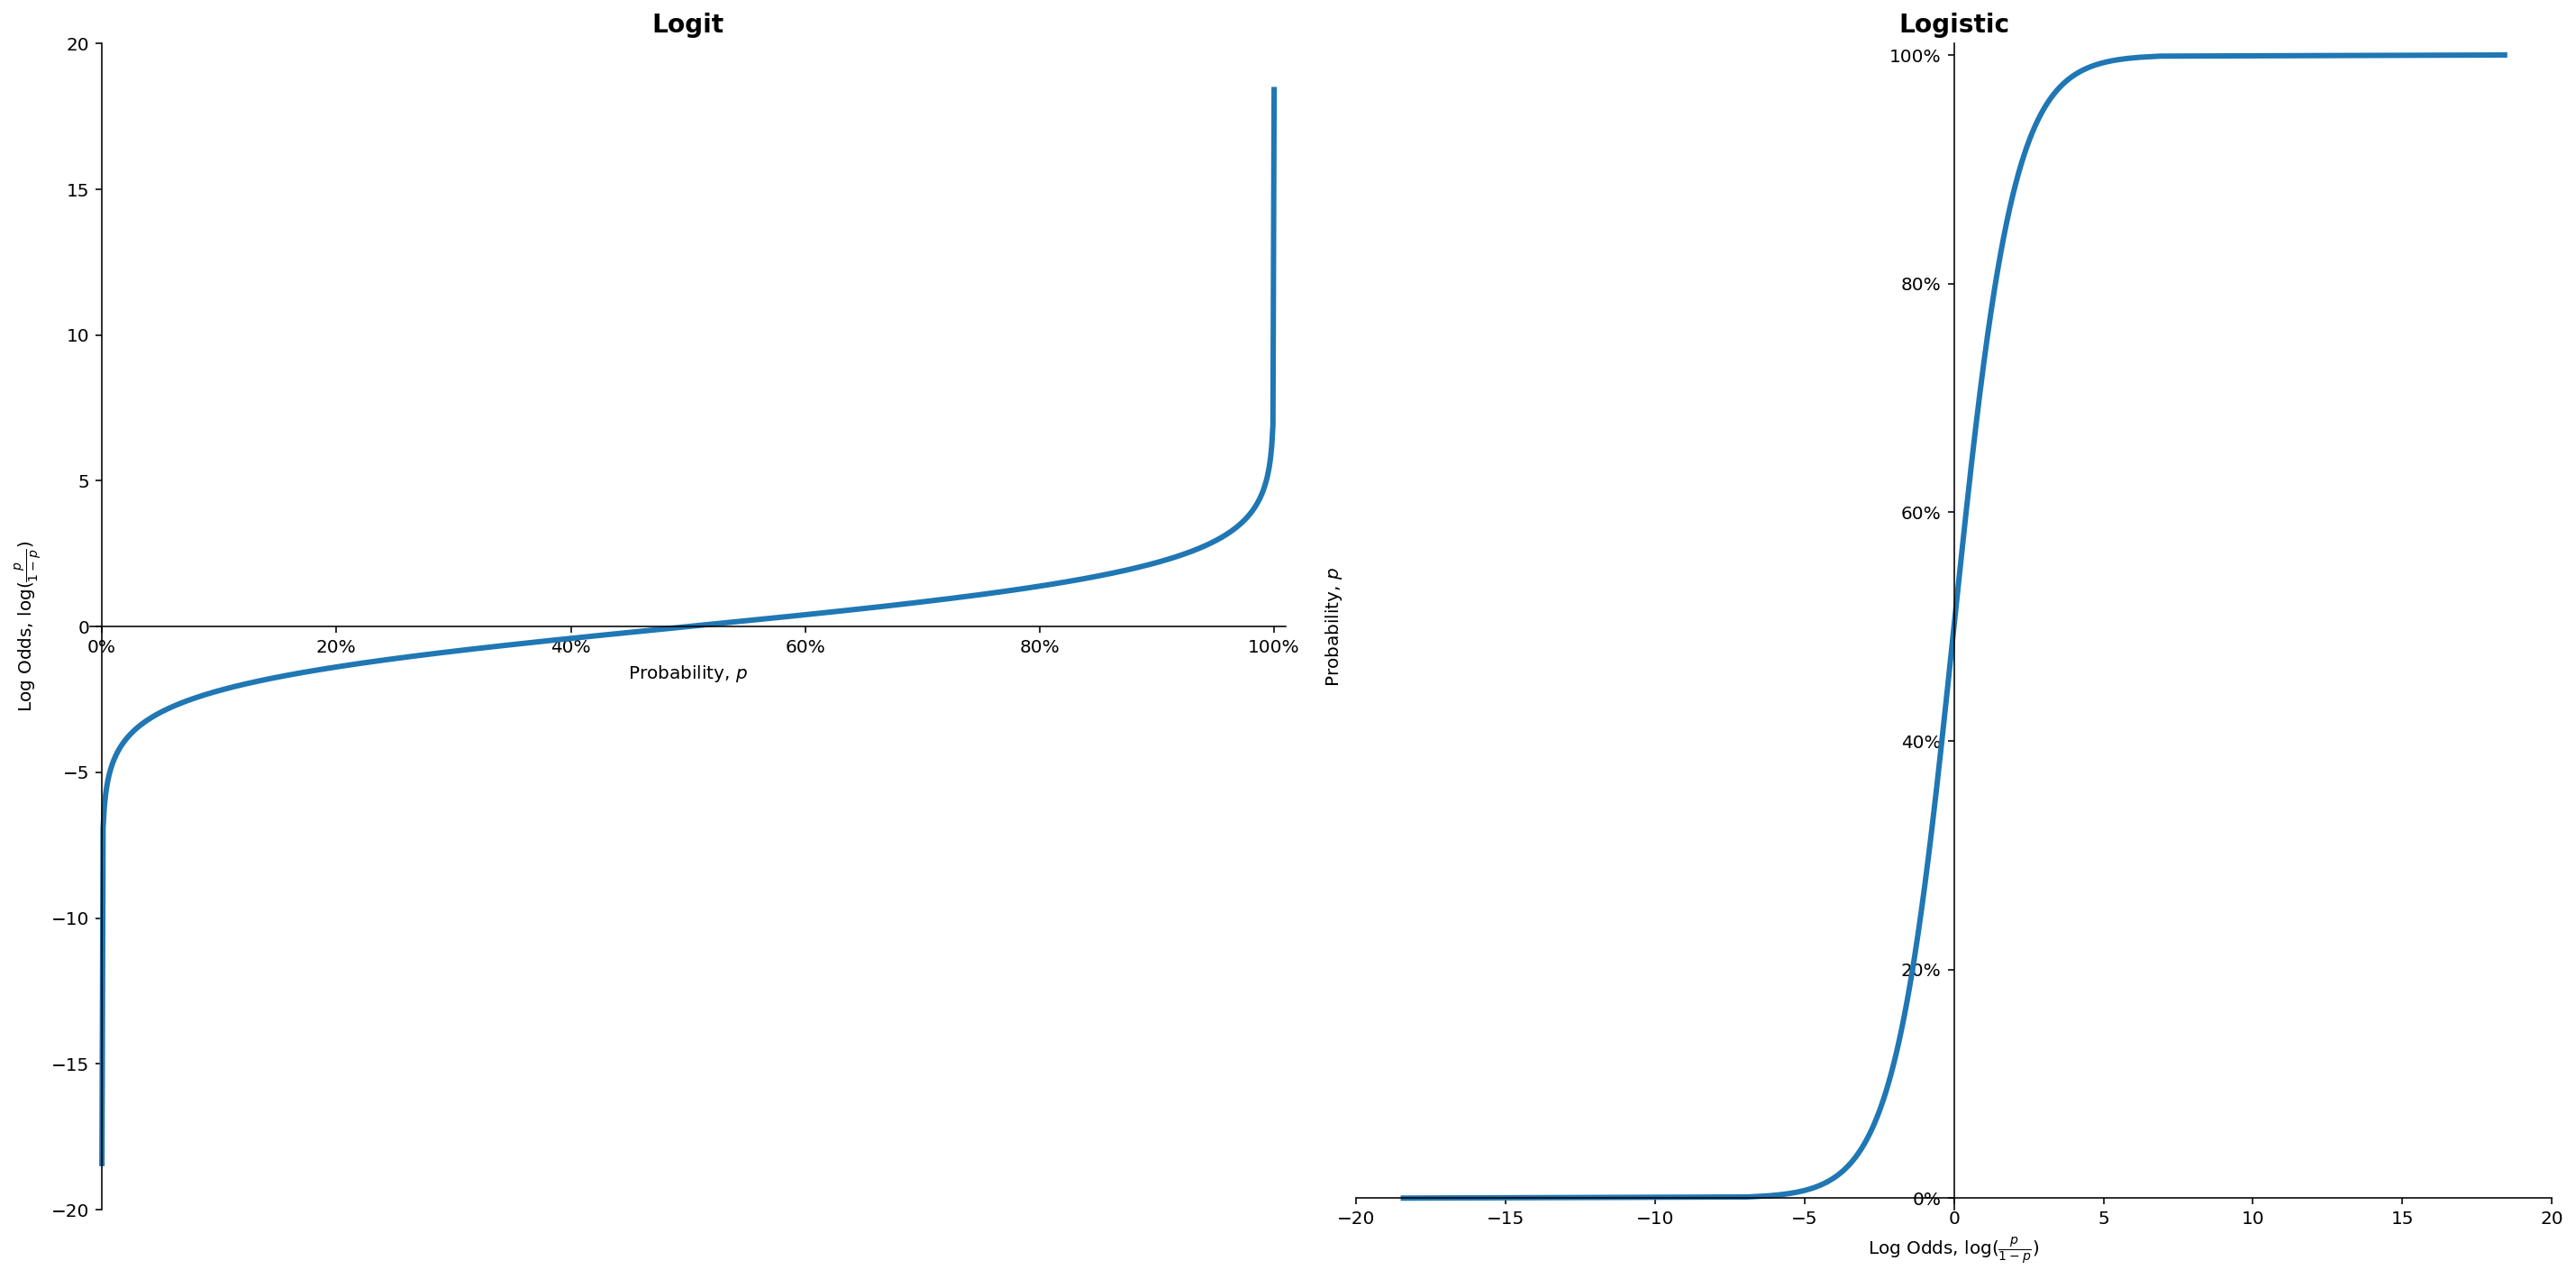

In [5]:
epsilon = 1e-8 # To prevent divide by 0 warning
p = np.linspace(epsilon, 1-epsilon,1000)
log_odds = np.log(p/(1-p))

fig, axes = plt.subplots(1,2, figsize=(20,10))
for i, ax in enumerate(axes):
    
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Plot logit function
    if i == 0:
        ax.set_title('Logit', weight='bold', size=14)
        ax.plot(p, log_odds, lw=3)
        ax.set_xlim(0-.01, 1+.01)
        ax.set_ylim(-20,20)
        ax.xaxis.set_major_formatter(PercentFormatter(1,0))
        ax.set_xlabel('Probability, $p$')
        ax.set_ylabel('Log Odds, $\log (\\frac{p}{1-p})$')
        ax.xaxis.get_major_ticks()[0].set_visible(False)
        
    # Plot logistic function
    else:
        ax.set_title('Logistic', weight='bold', size=14)
        ax.plot(log_odds, p, lw=3)
        ax.set_ylim(0-.01, 1+.01)
        ax.set_xlim(-20,20)
        ax.yaxis.set_major_formatter(PercentFormatter(1,0))
        ax.set_xlabel('Log Odds, $\log (\\frac{p}{1-p})$')
        ax.set_ylabel('Probability, $p$')
        ax.yaxis.set_label_coords(-0.01, 0.5)
        ax.yaxis.get_major_ticks()[0].set_visible(False)

plt.tight_layout()
plt.show();

My, my, my ... would you look at these function? Nice and symmetrical. Complementary log odds sum to $0$, whereas complementary probabilities sum to $1$. Legit -- on the left is the **logit** function. The logit is the *link* function for performing a **logistic regression** in that its inverse (plotted above, right; derived below; called the **logistic function**) is the curve we are trying to fit to the data (much like a line is what we are trying to fit to the data in the case of linear regression):

$$
\begin{align}
Y &= \pmb{X} \beta\\
\log \frac{p}{1-p} &= \pmb{X} \beta\\
p &= (1-p)e^{\pmb{X} \beta}\\
p + pe^{\pmb{X}  \beta} &= e^{\pmb{X} \beta}\\
p &= \frac{e^{\pmb{X} \beta}}{1 + e^{\pmb{X} \beta}} = \frac{1}{1 + e^{-\pmb{X} \beta}}
\end{align}
$$

A logistic regression is used when our independent variables might be continuous in scale, but our dependent variable is a *Bernoulli* distributed random variable (also called an *indicator*): it either is $0$ or $1$ with some probability $q=1-p$ or $p$, respectively. We'll talk more about random variables in our next lesson, but for now, it suffices to know what a logistic regression does and when we might use one; for example, we might use a logistic regression to predict whether a shipment is on time ($0$ if not, $1$ if so) based on several factors ($\pmb{X}$). This is why we need a *link* function: we need some way to map the continuous values that would result from the linear combination of the factors ($\pmb{X} \beta$) to a range for a valid probability (i.e., $[0,1]$).



Not only have we have derived the logistic function, but we have come full circle: probability → odds → log odds → probability! This won't be the last time we'll see the logistic function show up (e.g., activation function in neural net), though we have more groundwork to lay before we can return to demystifying the logistic regression fully. For fun, we use the help of `sklearn` to fit a logistic regression model to some data and to see the fit:

In [6]:
# Fabricate a toy dataset (i.e., a straight line with some normally-distributed noise)
xmin, xmax = -5, 5
n_samples = 100

X = np.random.normal(size=n_samples)
y = (X > 0).astype(np.float)
X[X > 0] *= 4
X += .3 * np.random.normal(size=n_samples)
X = X[:, np.newaxis]

# Preview the data
pd.DataFrame({'X': X.reshape(-1), 'y': y}).head()

,X,y
0,-1.603411,0.0
1,-0.043094,1.0
2,-1.204221,0.0
3,-0.702181,0.0
4,-0.730540,0.0


In [7]:
# Fit the logistics regression model
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X, y)

LogisticRegression(C=100000.0)

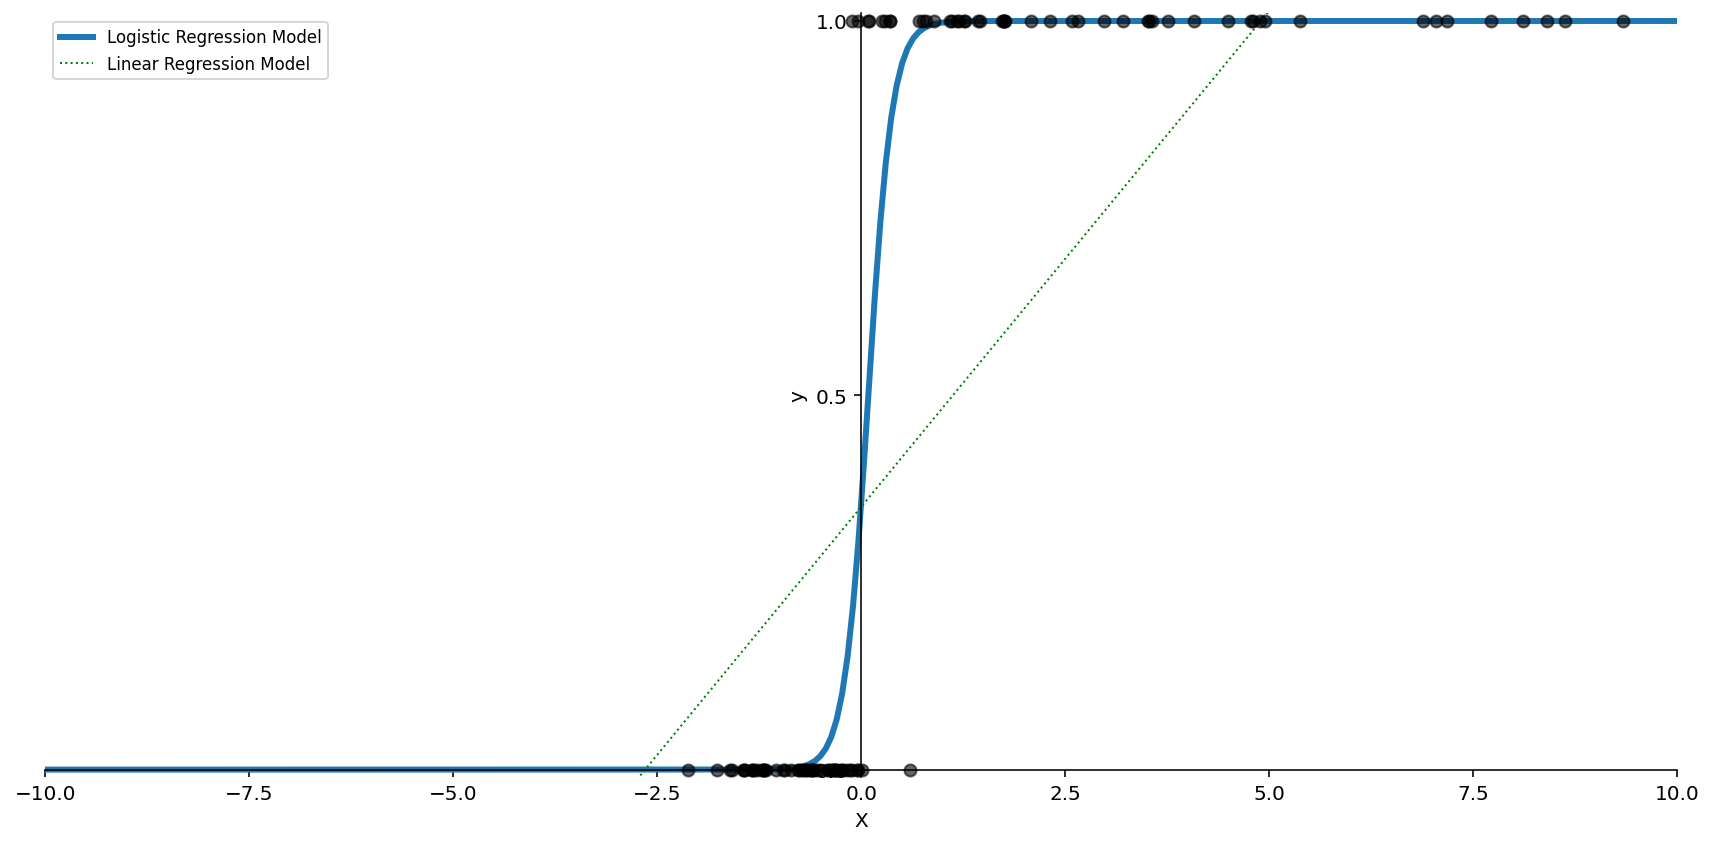

In [8]:
# Plot the data, linear & logistic regressions
plt.figure(1, figsize=(12, 6))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20, alpha=0.6)
X_test = np.linspace(-10, 10, 300)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, linewidth=3)

ols = linear_model.LinearRegression()
ols.fit(X, y)
plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, color='green', ls='dotted', linewidth=1)

plt.ylabel('y')
plt.xlabel('X')
plt.yticks([0, 0.5, 1])
plt.ylim(0-0.01, 1+0.01)
plt.xlim(-10, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="upper left", fontsize='small')

plt.gca().spines['bottom'].set_position('zero')
plt.gca().spines['left'].set_position('zero')    
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

### Odds Ratios & Log Odds Ratio

Even though odds (themselves) are ratios of probabilities, they are NOT odds ratios. One more time: **odds $\not\equiv$ odds ratios**! Odds ratios are what you'd expect: the ratio of odds. More pointedly, **an odds ratio relates how much more (or less) likely one event is happening versus another. Log odds ratios are the same, but log transformed.** Either way, they offer ways to compare the relatively likelihood of two events happening.

We intuitively understand what this means using probabilities. For example, if Christy Wong has a 90% chance of getting soup for lunch and other people only get soup 10% of the time, we can say that Christy is $9$ times more likely than others to get soup for lunch (inferred from observing many past lunch choices). Going back to our lesson on independence ([📚.2.1: Thinking Conditionally](https://drive.google.com/drive/folders/1ebuHd3aKd1VUDScSGeVzB9rxe2Q-yldF)), we can reach into our toolkit and grab a **contingency table**:

In [9]:
# Fabricate data on soup eating (drinking?) habits
params = dict(Christy=0.9, Others=0.1)
soup_data = pd.DataFrame({k: np.random.choice([0,1], 60, replace=True, p=[1-v, v]) 
                      for k, v in params.items()}).melt(value_name='soup_indicator', var_name='predictor')

# Build 2x2 contingency table
soup_abs_freq = pd.crosstab(soup_data['predictor'], soup_data['soup_indicator'], margins=True)
soup_abs_freq

soup_indicator,0,1,All
predictor,,,
Christy,11,49,60
Others,55,5,60
All,66,54,120


From here we have our choice of statistical test to help us figure out whether being Christy Wong has a statistically significant impact on your decision to include soup in your lunch plans:

- **The Fisher Exact Test** (which we'll cover once we talk about the *Hypergeometric* distribution)
- **The $\chi^{2}$ Test of Independence** (which we already covered in 📚.2.1)
- **The Wald Test** (which we'll talk about here since we're exploring odds ratios)

Okay, with our contingency table in place, let's practice calculating the odds ratio and log odds ratio for each "treatment" or "predictor" (these are synonymous; the "treatmentÆ here is either being a Christy Wong or not, but you can imagine this being the "the experimental drug group" vs. "the control/placebo group", respectively):

In [10]:
# Odds of getting soup if you are a Christy Wong
odds_CW = soup_abs_freq.loc['Christy', 1] / soup_abs_freq.loc['Christy', 0]

# Odds of getting soup if you are NOT a Christy Wong
odds_notCW = soup_abs_freq.loc['Others', 1] / soup_abs_freq.loc['Others', 0]

print(f"The odds that {soup_abs_freq.index[0]} gets soup: {odds_CW:.3f}")
print(f"The odds that {soup_abs_freq.index[1]} gets soup: {odds_notCW:.3f}")

The odds that Christy gets soup: 4.455
The odds that Others gets soup: 0.091


Okay, so to get the odds ratio, we simply divide the two:

In [11]:
# Odds ratio (Soupfor Lunch: Christy vs. Others)
odds_ratio = odds_CW/odds_notCW
print(f"The odds ratio between Christy and Others for having soup for lunch: {odds_ratio:.3f}")
print(f"Being a Christy Wong increases your odds of getting soup for lunch by {(odds_ratio-1):.0%}.")

The odds ratio between Christy and Others for having soup for lunch: 49.000
Being a Christy Wong increases your odds of getting soup for lunch by 4800%.


Wow. It feels fairly obvious that being Christy Wong significantly impacts your chance of having soup for lunch. Just like $R^{2}$ in linear regression, the odds ratio (and log odds ratio) tell us the effect size, or how associated (read: correlated) getting soup is with being a Christy Wong.

But how can we be sure when the evidence isn't as overwhelming? After all, we only have 60 days of data (a *sample*) to estimate the true proportion of soup-chasing for Christy and others. We perform a statistical test! But first, a quick PSA:

>Importantly, this is *NOT* the same as what we calculated above which said being a Christy Wong **increases the probability of getting soup for lunch by 800%** -- this is the **relative risk**. So, the **odds ratio (OR) $\not\equiv$ relative risk (RR)**! They are close when small, but the odds ratio quickly blows up (relative to the RR), a fact that is very often exploited by media reporting on scientific studies to exaggerate the true effect of experimental variables. (There's also the added fact these can't be compared because in the real world we can't observe population parameters, i.e., the "true" proportion of times a Christy Wong indulges in the warmth of soup for her midday meal.)

Alright, back to the regularly scheduled program. First, let's get the log odds ratio. I won't get into "why" of it now, but **if we repeatedly sampled soup rates, the log odds ratios would be normally distributed**. If we assume a null hypothesis that the log odds would be 0 (in English, "If there was no effect of being a Christy Wong on deciding on soup for lunch, we'd expect no difference in the incidence/proportion/probability/odds/*log odds* of soup for lunch."): $H_{0}: \log (\text{OR}) = 0$.

In [12]:
# Log odds
log_odds_ratio = np.log(odds_CW / odds_notCW)

print(f"The log odds ratio between Christy and Others for having soup for lunch: {log_odds_ratio:.4f}")

The log odds ratio between Christy and Others for having soup for lunch: 3.8918


Again, without getting bogged down on the derivation, we can calculate our test statistic: the log odds ratio divided by the estimate of the standard error (just like we'd do in a $t$-test, for example). The actual calculation below isn't super important to grasp; again, we're being hand-wavy on the rigor to get to an answer.

In [13]:
# Add intercept term
soup_data['intercept'] = 1

# Fit logistic regression
y = soup_data['soup_indicator']
X = pd.get_dummies(soup_data.drop(columns='soup_indicator')).drop(columns='predictor_Others')

model = sm.Logit(y, X)
fitted_model = model.fit()

# Get summary
fitted_model.summary()

Optimization terminated successfully.
         Current function value: 0.381623
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         soup_indicator   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Fri, 10 Jul 2020   Pseudo R-squ.:                  0.4454
Time:                        20:11:07   Log-Likelihood:                -45.795
converged:                       True   LL-Null:                       -82.577
Covariance Type:            nonrobust   LLR p-value:                 9.744e-18
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -2.3979      0.467     -5.134      0.000      -3.313      -1.482
predictor_Christy     3.8918      0.574      6.780      0.000       2.767       5.017
=====================================================================================
"""

## 3. Attribution of Growth of a Ratio (or Product)

Sometimes we'd like to know what drives the change in a ratio from one period to the next. We will illustrate a way to do this attribution to the divisor (i.e., denominator) and dividend (i.e., numerator) using a real example from NJ's work below.

Other times, we wish to understand how changes to a product can be broken out into changes in its constituent parts. That'll be our second case, using a common and simple example from consulting case interviews.

### Case: Customs Attach Rate

Clients that use Flexport's customs offering almost always use Flexport's freight offerings as well. We measure this phenomenon by defining a metric: the **customs attach rate** (sometimes referred to as just "attach rate" here).

Formally, the attach rate ($a$) is the ratio of Flexport customs shipments ($S_c$) to Flexport freight shipments ($S_f$):

$$
a = \frac{S_c}{S_f}
$$

We see directly how $a$ behaves based on what we know about the divisor and dividend:

$$
a \propto S_{c}, S_{f}^{-1}
$$

But what would happen if $S_{c}$ and $S_{f}$ move in the same direction? What direction would $a$ move? Well, it depends: 

- If the rate of change of $S_{c}$ is greater than that of $S_{f}$, then $a$ increases.
- If the rate of change of $S_{f}$ is greater than that of $S_{c}$, then $a$ decreases.

By attributing the change in attach rate to the numerator or denominator, we can more clearly understand what is driving this change. But *how* should we divide up responsibility between the numerator and the denominator for the change in the attach rate?

In [14]:
# Load attach rate data
conn, cur = get_connection()
cur.execute("USE DATABASE ANALYTICS")
df = get_data('attach_over_time.sql', 'file', conn)

# Preview data
df.head()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


,client,client_id,month,year,segment_name,count_customs_shipments,count_freight_shipments,customs_attach_rate
0,BetterBack,3030,3,2016,Emerging,1,1,1.0
1,BetterBack,3030,4,2016,Emerging,2,1,2.0
2,BetterBack,3030,6,2016,Emerging,2,1,2.0
3,BetterBack,3030,8,2016,Emerging,2,2,1.0
4,BetterBack,3030,9,2016,Emerging,1,0,NaN


For the purposes of this exercise, let's just focus on one customer: `Peak Design`.

In [15]:
# Isolate client, clean up time period / dates, set index to date
data = df.copy().query('client == "Peak Design"').drop(columns=['client_id', 'client', 'segment_name'])
data['day'] = 1
data['month'] = (data['month'] % 12) + 1
data['date'] = pd.to_datetime(data[['year', 'month', 'day']]) - pd.Timedelta('1 day')
data = data.drop(columns=['month', 'year', 'day'])
data = data.set_index('date')

First, let's ask ourselves the question, "What is an average ratio (e.g., a client's average attach rate over $x$ months for $x \in \mathbb{Z}^{+}$)"? I think we can all agree that it is generally a bad idea to simply add up each period's ratio and divide by the number of periods.

A better representation of an average attach (for our purposes) over $k$ months, $\overline{a}_{k}$, is computed by dividing the cumulative customs shipments by the cumulative freight shipments:

$$
\overline{a}_{k} = \frac{\sum_{i}^{k} S_{c_{i}}}{\sum_{i}^{k} S_{f_{i}}}
$$

Now, let's consider the next month, when $i=k+1$, in relation to the $k$ months for which we've calculated an average attach rate. Notice the following:

- If $a_{i=k+1} = \overline{a}_{k}$, then $\overline{a}_{k+1} = \overline{a}_{k}$.
- If $a_{i=k+1} < \overline{a}_{k}$, then $\overline{a}_{k+1} < \overline{a}_{k}$.
- If $a_{i=k+1} > \overline{a}_{k}$, then $\overline{a}_{k+1} > \overline{a}_{k}$.

**Upshot**: While each month's attach rate impacts the cumulative attach rate less over time, the *direction* of this impact is always consistent!

Now, think carefully about what $\frac{\overline{a}_{k+1}}{\overline{a}_{k}}$ resembles (hint: scroll up)...

Feels good, doesn't it? Yessir, we've got a ratio of ratios and you know damn well we 'bout to $\log$ that thang. Why? Why not (read: review the first section)! Let $g_{c}$, $g_{s}$ be growth of customs and freight shipments in period $i=k+1$, respectively. Immediately, we can establish:

$$
\begin{align}
\overline{a}_{k} \frac{(1+g_{c})}{(1+g_{f})} & = \overline{a}_{k+1}\\
\log \left(\frac{1+g_{c}}{1+g_{f}}\right) = \log(1+g_{c}) - \log(1+g_{f}) &= \log \left(\frac{\overline{a}_{k+1}}{\overline{a}_{k}}\right)\\
\underbrace{g_{c}-g_{f}}_{\text{attach rate growth, $\Delta\%$}} & \approx \log \left(\frac{\sum_{i}^{k+1} S_{c_{i}}}{\sum_{i}^{k+1} S_{f_{i}}} \div \frac{\sum_{i}^{k} S_{c_{i}}}{\sum_{i}^{k} S_{f_{i}}} \right) = \log \left(\frac{\sum_{i}^{k+1} S_{c_{i}}}{\sum_{i}^{k+1} S_{f_{i}}} \times \frac{\sum_{i}^{k} S_{f_{i}}}{\sum_{i}^{k} S_{c_{i}}} \right)\\
& \approx \underbrace{\log \left(\frac{\sum_{i}^{k+1} S_{c_{i}}}{ \sum_{i}^{k} S_{c_{i}}}\right)}_{\text{growth attributed to $\Delta\%$ customs}} + \underbrace{\log \left(\frac{\sum_{i}^{k} S_{f_{i}}}{ \sum_{i}^{k+1} S_{f_{i}}}\right)}_{\text{growth attributed to $\Delta\%$ freight}}
\end{align}
$$

Now that we've got the two additive components, we can answer a question like "How much of month $j$'s increase in attach rate was due to customs?" With a little extra care, we can even begin to [categorize patterns of movements](https://docs.google.com/spreadsheets/d/1Lhtn98I9Zt9P5yEtIvhQ3viPDQhH7SOIu3CjyzREkpM/edit?usp=sharing) in our metric!

In [16]:
# Calculate cumulative (average) attach rates
data[['cumul_customs_shipments', 'cumul_freight_shipments']] = data[['count_customs_shipments', 'count_freight_shipments']].cumsum()
data['cumul_attach_rate'] = data['cumul_customs_shipments'] / data['cumul_freight_shipments']

In [17]:
# MoM % change to attach rate
data['mom_delta_attach_rate'] = data['cumul_attach_rate']/data.shift(1)['cumul_attach_rate'] - 1

# Approximated MoM % change to customs shipments, freight shipments
data['mom_delta_customs_shipments'] = np.log(data['cumul_customs_shipments']/data.shift(1)['cumul_customs_shipments'])
data['mom_delta_freight_shipments'] = np.log(data.shift(1)['cumul_freight_shipments']/data['cumul_freight_shipments'])

With our attribution done, let's see how good our approximations are:

In [18]:
# Absolute error (magnitude)
data['abs_error'] = np.abs(data['mom_delta_attach_rate'] - (data['mom_delta_customs_shipments'] + data['mom_delta_freight_shipments']))

# Relative error (magnitude)
data['relative_error'] = data['abs_error'] / np.abs(data['mom_delta_attach_rate'])

In [19]:
# Style dataframe
pct_cols = [col for col in data.columns if any(substr_match in col for substr_match in ['rate', 'mom_delta', 'error'])]
fmt_list = ["{:.2%}" for col in pct_cols]

# Preview data and attribution
data.tail(10).style.format(dict(zip(pct_cols, fmt_list)))

,count_customs_shipments,count_freight_shipments,customs_attach_rate,cumul_customs_shipments,cumul_freight_shipments,cumul_attach_rate,mom_delta_attach_rate,mom_delta_customs_shipments,mom_delta_freight_shipments,abs_error,relative_error
date,,,,,,,,,,,
2019-10-31 00:00:00,54,55,98.18%,601,655,91.76%,0.65%,9.41%,-8.77%,0.00%,0.32%
2019-11-30 00:00:00,55,59,93.22%,656,714,91.88%,0.13%,8.76%,-8.62%,0.00%,0.07%
2018-12-31 00:00:00,56,58,96.55%,712,772,92.23%,0.38%,8.19%,-7.81%,0.00%,0.19%
2020-01-31 00:00:00,30,31,96.77%,742,803,92.40%,0.19%,4.13%,-3.94%,0.00%,0.10%
2020-02-29 00:00:00,19,20,95.00%,761,823,92.47%,0.07%,2.53%,-2.46%,0.00%,0.03%
2020-03-31 00:00:00,29,29,100.00%,790,852,92.72%,0.28%,3.74%,-3.46%,0.00%,0.14%
2020-04-30 00:00:00,30,31,96.77%,820,883,92.87%,0.15%,3.73%,-3.57%,0.00%,0.08%
2020-05-31 00:00:00,18,18,100.00%,838,901,93.01%,0.15%,2.17%,-2.02%,0.00%,0.08%
2020-06-30 00:00:00,21,21,100.00%,859,922,93.17%,0.17%,2.48%,-2.30%,0.00%,0.09%


### Case: Revenue Growth

Let's simplify our freight forwarding business by breaking down (gross) revenue growth (say, last month), $R$, into two numbers (both in nominal terms): 

- volume ($V$), number of TEUs
- price ($P$), average sales price per TEU

Using the same $log$ approximations from above (for relatively small $g$), we can decompose revenue growth last month into its constituent parts. We can figure out which component "moved the needle" more in a given month by mimicking the logic above, except for a product rather than a ratio:

$$
\begin{align}
\begin{cases}
P_{t+1} \cdot V_{t+1} &= R_{t+1}\\
P_{t} \cdot V_{t} &= R_{t}\\
\end{cases}\\
\frac{P_{t+1} \cdot V_{t+1}}{P_{t} \cdot V_{t}} &= \frac{R_{t+1}}{R_{t}}\\
g_{P} + g_{V} \approx \log(1+g_{P}) + \log(1+g_{V}) &= \log(1+g_{R}) \approx g_{R} 
\end{align}
$$

The keenest observer will notice that this is eerily reminiscent of the "product rule" from derivative calculus! In derivative calculus, we are most interested in seeing how a small change to an input (e.g., $x$) translates into a change in the output (e.g., $f(x))$. Really, this is the same thing we're interested in here, just in reverse. 

Let's quickly review the intuition behind the "product rule":

![Product Rule Geometric Interpretation](https://betterexplained.com/wp-content/uploads/derivatives/productrule.png)

The "product rule" answers the question, "How much does $h$ change if we 'jiggle' $x$ a little bit and $h$ is a product of $f$ and $g$?" (Just to help develop the intuition, let's assume that $f$ and $g$ are both monotonically increasing functions so we can rely on the picture above to geometrically illustrate the "product rule.")

The red square ($x$) is the input to the function $h$, which is simply the product of the functions $f$ and $g$ whose input is also $x$. $\text{d}x$ is that jiggle we talked about--a very, very small change to $x$. "Jiggling" $x$ a little bit will result in a small change in the aforementioned functions (i.e., $\text{d}f$ and $\text{d}g$); changes to these functions will ultimately result in some change to $h$: $\text{d}h$.

Since $h = f \cdot g$, $\text{d}h = \text{d}(f \cdot g)$. $\text{d}h$ is the sum of the dotted regions in the graphic above: 

$$
\text{d}h = (\text{d}g \cdot f) + (\text{d}f \cdot g) + (\text{d}g \cdot \text{d}f)
$$

- the contribution to $\text{d}h$ from holding $f$ constant and applying the change to $g$: $\text{d}g \cdot f$
- the contribution to $\text{d}h$ from holding $g$ constant and applying the change to $f$: $\text{d}f \cdot g$
- the contribution to $\text{d}h$ from both $f$ and $g$ simultaneously: $\text{d}f \cdot \text{d}g$

In the limit, the last term approaches $0$ zero so much faster than the other two terms. Putting this result in terms of $\text{d}x$ leaves us with the "product rule" as we know it:

$$
\frac{\text{d}h}{\text{d}x} = f \frac{\text{d}g}{\text{d}x} + g \frac{\text{d}f}{\text{d}x}
$$


For our purposes, price and volume don't have a common input, so we don't need to worry about keeping track of how the changes to these variables relate to changes for some $x$. Notice how the "product rule" interpretation lines up with our set up. If we consider that the most recent period $t+1$ represents the *change* to each period and the sum of each variable thru the $t$th period is the each variables *current* value, we see:

$$
\begin{align}
\frac{P_{t+1} \cdot V_{t+1}}{P_{t} \cdot V_{t}} &= \frac{R_{t+1}}{R_{t}}\\
(P_{t} + g_{P})(V_{t} + g_{V}) &= R_{t} + g_{R}\\
P_{t}V_{t} + g_{P}V_{t} + P_{t}g_{V} + g_{V}g_{P} &= R_{t} + g_{R}\\
g_{P}V_{t} + g_{V}P_{t} + g_{V}g_{P} &= g_{R}\\
(g_{P} \cdot V_{t}) + (g_{V} \cdot P_{t}) &\approx g_{R}
\end{align}
$$

Notice how this is basically what we do for the "product rule," but as a discrete approximation:

$$
(\Delta P \cdot V_{t}) + (\Delta V \cdot P_{t}) = \Delta R
$$

## 4. Wrap Up

**Congratulations**: You're ready to be [consultant](https://www.twostatesconsulting.com/)! 

I recognize that the content herein might seem a bit simplistic, but it's worth spending some time to ruminate on these basic concepts. Being able to quickly approximate the relation of \[relatively small\] changes to two quantities will help you better reason through statements that are made about aggregations or systems of these quantities (e.g., sensitivity analysis of net profit margin of a highly levered company given a particular expectation of revenue growth).

<br>

![JGoad's Meme Factory](https://i.imgflip.com/47q5kc.jpg)